<table>
    <tr> <td valign="center"> <img src="LogoSTIMULATE.png" width=450pt> </td>
        <td valign="center" width="80%"> <b>Workshop on Mathematical Modeling and Numerical Analysis for Exascale, April 8-18, 2019</b></td>
        <td valign="center"> <img src="LogoHU.png" width=150pt> </td>
    </tr>
</table>

# Programming 5

## Finite volume methods and particle based methods for CFD

### Advection Equation in 1D

Consider the advection equation
\begin{align*}
  \partial_t u(t,x) + c \partial_x u(t,x) = 0
\end{align*}

on the spatial interval $[0,1]$ and the time interval $[0,10]$ with the boundary condition

\begin{align*}
  u(t,0) = \text{sin}(t)
\end{align*}
and the initial condition
\begin{align*}
  u(0,x) = x
\end{align*}

1) Derive the FVM scheme as described in the lecture 5 as
\begin{align*}
	  \bar u'(t) = B \bar u(t) + r(t), \qquad  \bar u(t):=
	  \begin{pmatrix}
	    \vdots \\ \bar u_i(t) \\ \vdots
	  \end{pmatrix}
\end{align*}
Attention: Do not forget the handling of the boundaries!

In [ ]:
B = 

2) Choose $c=1$ and solve the ordinary differential equation by the explicit Euler method.

3) Choose $c=-1$ and solve the ordinary differential equation by the explicit Euler method.

4) Do you observe difficulties in one of the cases?

5) What happens if you replace the boundary condition by
\begin{align*}
  u(t,1) = \text{sin}(t)
\end{align*}

### Poisson Equation and Bratu Problem in 2D

Install the packages pyfvm and vtk, e.g. by 'pip3 install pyfvm, vtk'. The package pyfvm provides finite volume methods in python. The package vtk can be used for visualization.

In [4]:
# imports for finite volume computations

# mehszoo generates meshes for FEM/FVM computations
import meshzoo

# meshplex computes control volumes, cell circumcenters, surface areas, etc. for FVM discretizations
import meshplex

# pyfvm provides methods for setting up finite volume equation systems
import pyfvm
from pyfvm.form_language import *

# scipy.sparse provides linear solvers for sparse systems
from scipy.sparse import linalg

ModuleNotFoundError: No module named 'meshzoo'

We consider the (linear) <font color='blue'>Poisson equation</font>:
\begin{align}
  \Delta u &= r && \text{in }\Omega\\
  u &= 1 && \text{on }\partial\Omega\
\end{align}
and the (nonlinear) <font color='blue'>Bratu problem</font>:
\begin{align}
  \Delta u + C\exp(u) &= 0 && \text{in }\Omega\\
  u &= 0 && \text{on }\partial\Omega\
\end{align}

In [49]:
# provide differential equation (Poisson equation)
class Poisson(object):
    def apply(self, u):
        def f(x):
            return -n_dot_grad(u(x))
        def r(x):
            return 1.0
        return integrate(f, dS) - integrate(r, dV)
    # define Dirichlet boundary conditions
    def dirichlet(self, u):
        def b(x):
            return u(x) -1.0
        return [(b , Boundary())]

In [64]:
# provide differential equation (Bratu problem)
from sympy import exp, sin, cos
class Bratu(object):
    def apply(self, u):
        C = -2.0
        def f(x):
            return -n_dot_grad(u(x))
        def r(x):
            return C * exp(u(x))
        return integrate(f, dS) - integrate(r, dV)

    def dirichlet(self, u):
        def b(x):
            return u(x)    
        return [(u, Boundary())]

In [65]:
# create a mesh for a rectangular domain
vertices, cells = meshzoo.rectangle(0.0, 2.0, 0.0, 1.0, 40, 20)
mesh = meshplex.MeshTri(vertices, cells)

In [66]:
# generate the discretized system for linear Poisson problem
matrix, rhs = pyfvm.discretize_linear(Poisson(), mesh)

# solve the linear discretized system with a sparse solver
u_Poisson = linalg.spsolve(matrix, rhs)

In [67]:
# generate the discretized system for nonlinear Bratu problem
F, jacobian = pyfvm.discretize(Bratu(), mesh)

def jacobian_solver(u0, rhs):
    from scipy.sparse import linalg
    jac = jacobian.get_linear_operator(u0)
    return linalg.spsolve(jac, rhs)

# solve the nonlinear discretized system
u0 = numpy.zeros(len(vertices))
u_Bratu = pyfvm.newton(F.eval, jacobian_solver, u0)

||F(u)|| = 1.411789e-01
||F(u)|| = 1.210984e-03
||F(u)|| = 1.272831e-07
||F(u)|| = 1.568845e-15


In [68]:
# write the solution to vtk output file
mesh.write('out_Bratu.vtk', point_data={'u': u_Bratu})
mesh.write('out_Poisson.vtk', point_data={'u': u_Poisson})

Number of points: 800
Number of elements:
  triangle: 1482
Point data: u


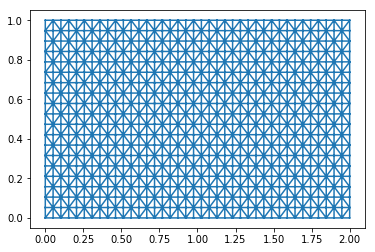

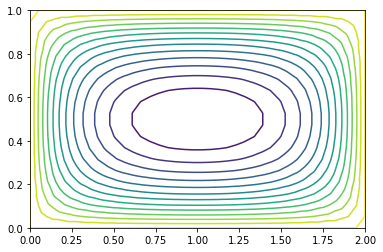

In [72]:
# plot data from output vtk file
import vtk
import meshio
import matplotlib.pyplot as plt

#out_mesh = meshio.read('out_Poisson.vtk')
out_mesh = meshio.read('out_Bratu.vtk')
print(out_mesh)
out_points = out_mesh.points
out_cells = out_mesh.cells
out_triangles = out_cells['triangle']
out_data = out_mesh.point_data
out_u = out_data['u']
#print(out_u)

# show the mesh
plt.triplot(out_points[:,0], out_points[:,1], out_triangles)
# show the solution
plt.figure()
plt.tricontour(out_points[:,0], out_points[:,1], out_triangles, out_u, 16)

#plt.gca().set_aspect('equal')